In [4]:
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model, image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pathlib
import cv2
import os
import random

### Paths

In [6]:
images_path = '../../../Dataset/teamphotos_ready/'
#identity_path = '../../../Dataset/identity_test.txt'
#attributes_path = '../../../Dataset/list_attr_celeba.txt'

### Hyperparameters

In [7]:
images_num=20

train_size=0.6
test_val_proportion=0.5

image_shape=(224, 224, 3)

batch_size=10
lr=0.00001

## Creating pairs

In [8]:
#def get_balanced_pair(i, path):
#    containing_id_list = []
#    # getting random identity from the provided column to use for balanced pair
#    photos = os.listdir(path)
#    photos = [x for x in photos if "train" in x]
    
#    if i + 1 == len(photos)-1:
#        containing_id_list.append(photos[i])
#        containing_id_list.append(photos[i+1])
#        negative = photos[0]
#    else:
#        containing_id_list.append(photos[i])
#        containing_id_list.append(photos[i+1])
#        negative = photos[i+2]

        
    
    # random pictures for pair generation
    #df_without_id = df.loc[df[pairing_column] != random_id]
    #negative = df[pairing_column].sample(1, replace=False).to_list()
    
#    return [[containing_id_list[0], containing_id_list[1], 1], [containing_id_list[0], negative, 0]]

In [9]:
def slicer(array, index_from, index_to):
    array_copy = array.copy()
    del array_copy[index_from:index_to]
    return array_copy

In [10]:
def get_balanced_pair(path):
    containing_id_list = []
    photos = os.listdir(path)
    
    photo_sample = random.sample(photos, 1)
    photo_sample = photo_sample[0]
    photo_index = photos.index(photo_sample)
    if photo_index % 2 == 1:
        containing_id_list.append(photos[photo_index])
        containing_id_list.append(photos[photo_index - 1])
        negative = random.sample(slicer(photos, photo_index - 1, photo_index + 1), 1)
        negative = negative[0]
        return [[containing_id_list[0], containing_id_list[1], 1], [containing_id_list[0], negative, 0]]
    else:
        containing_id_list.append(photos[photo_index])
        containing_id_list.append(photos[photo_index + 1])
        negative = random.sample(slicer(photos, photo_index, photo_index + 1), 1)
        negative = negative[0]
        return [[containing_id_list[0], containing_id_list[1], 1], [containing_id_list[0], negative, 0]]
    

In [11]:
balanced_pairs = []
random.seed(64)

for i in range(images_num):
    pair = get_balanced_pair(images_path)
    balanced_pairs.append(pair[0])
    balanced_pairs.append(pair[1])
    
df_train = pd.DataFrame(balanced_pairs, columns =['left', 'right', 'label'])
df_train['left'] = images_path + '/' + df_train['left']
df_train['right'] = images_path + '/' + df_train['right']

In [12]:
df_train

,left,right,label
0,../../../Dataset/teamphotos_ready//train_25.jpg,../../../Dataset/teamphotos_ready//train_24.jpg,1
1,../../../Dataset/teamphotos_ready//train_25.jpg,../../../Dataset/teamphotos_ready//train_12.jpg,0
2,../../../Dataset/teamphotos_ready//train_6.jpg,../../../Dataset/teamphotos_ready//train_7.jpg,1
3,../../../Dataset/teamphotos_ready//train_6.jpg,../../../Dataset/teamphotos_ready//train_5.jpg,0
4,../../../Dataset/teamphotos_ready//train_21.jpg,../../../Dataset/teamphotos_ready//train_23.jpg,1
5,../../../Dataset/teamphotos_ready//train_21.jpg,../../../Dataset/teamphotos_ready//train_4.jpg,0
6,../../../Dataset/teamphotos_ready//train_7.jpg,../../../Dataset/teamphotos_ready//train_6.jpg,1
7,../../../Dataset/teamphotos_ready//train_7.jpg,../../../Dataset/teamphotos_ready//train_1.jpg,0
8,../../../Dataset/teamphotos_ready//train_15.jpg,../../../Dataset/teamphotos_ready//train_16.jpg,1
9,../../../Dataset/teamphotos_ready//train_15.jpg,../../../Dataset/teamphotos_ready//train_18.jpg,0


In [13]:
balanced_pairs_test = []
random.seed(128)

for i in range(images_num):
    pair = get_balanced_pair(images_path)
    balanced_pairs_test.append(pair[0])
    balanced_pairs_test.append(pair[1])
    
df_test = pd.DataFrame(balanced_pairs_test, columns =['left', 'right', 'label'])
df_test['left'] = images_path + '/' + df_test['left']
df_test['right'] = images_path + '/' + df_test['right']

In [14]:
df_test

,left,right,label
0,../../../Dataset/teamphotos_ready//train_16.jpg,../../../Dataset/teamphotos_ready//train_15.jpg,1
1,../../../Dataset/teamphotos_ready//train_16.jpg,../../../Dataset/teamphotos_ready//train_24.jpg,0
2,../../../Dataset/teamphotos_ready//train_26.jpg,../../../Dataset/teamphotos_ready//train_3.jpg,1
3,../../../Dataset/teamphotos_ready//train_26.jpg,../../../Dataset/teamphotos_ready//train_20.jpg,0
4,../../../Dataset/teamphotos_ready//train_13.jpg,../../../Dataset/teamphotos_ready//train_14.jpg,1
5,../../../Dataset/teamphotos_ready//train_13.jpg,../../../Dataset/teamphotos_ready//train_26.jpg,0
6,../../../Dataset/teamphotos_ready//train_1.jpg,../../../Dataset/teamphotos_ready//train_10.jpg,1
7,../../../Dataset/teamphotos_ready//train_1.jpg,../../../Dataset/teamphotos_ready//train_14.jpg,0
8,../../../Dataset/teamphotos_ready//train_2.jpg,../../../Dataset/teamphotos_ready//train_20.jpg,1
9,../../../Dataset/teamphotos_ready//train_2.jpg,../../../Dataset/teamphotos_ready//train_7.jpg,0


### Create test train val split

In [15]:
#X_train, X_rem, y_train, y_rem = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], train_size=train_size, random_state = 101, shuffle=True)

#X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=test_val_proportion)

In [16]:
X_train = df_train[["left", "right"]]
Y_train_label = df_train[["label"]]

In [17]:
X_test = df_test[["left", "right"]]
Y_test_label = df_test[["label"]]

In [18]:
print('=====Training=====')
print(X_train.shape)
print(Y_train_label.shape)

#print('=====Validation=====')
#print(X_val.shape)
#print(Y_val.shape)

print('=====Testing=====')
print(X_test.shape)
print(Y_test_label.shape)

=====Training=====
(40, 2)
(40, 1)
=====Testing=====
(40, 2)
(40, 1)


### Loading pairs into TF Dataset

In [19]:
def preprocessing(left, right):
    return convert_to_img(left), convert_to_img(right)


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.per_image_standardization(img)
    #img = tf.expand_dims(img, axis=0)
    img = tf.reshape(img,(224,224,3))
    return img

def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [20]:
def create_dataset(features, labels):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    labels_ds = tf.data.Dataset.from_tensor_slices(labels.values)
    
    feature_ds = feature_ds.map(preprocessing)
    labels_ds = labels_ds.map(label_preprocessing)
    
    dataset = tf.data.Dataset.zip((feature_ds, labels_ds))
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

def create_dataset_no_labels(features):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    feature_ds = feature_ds.map(preprocessing)
    
    feature_ds = feature_ds.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    feature_ds = feature_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return feature_ds

def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [21]:
train_ds = create_dataset(X_train, Y_train_label)
val_ds = create_dataset(X_test, Y_test_label)

## NN model

In [22]:
left_input = layers.Input(shape=(224, 224, 3), name='left_input')
right_input = layers.Input(shape=(224, 224, 3), name='right_input')

### ResNet50 model

In [23]:
def resnet_network():
    input = layers.Input(shape=(224, 224, 3))
    
    resnet=ResNet50(
        input_tensor=input,
        include_top=False,
        input_shape=image_shape,
        pooling='avg',
        weights='imagenet',
        classes=2)

    for layer in resnet.layers[0:-1]:
        layer.trainable = False

    return Model(input, outputs=resnet.output, name='resnet50')

In [24]:
def conv_network(): 
    input = layers.Input(shape=network_input_shape, name='input_image')
    
    # First block
    c1 = layers.Conv2D(64, (10,10), activation='relu')(input)
    m1 = layers.MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = layers.Conv2D(128, (7,7), activation='relu')(m1)
    m2 = layers.MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = layers.Conv2D(128, (4,4), activation='relu')(m2)
    m3 = layers.MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = layers.Conv2D(256, (4,4), activation='relu')(m3)
    f1 = layers.Flatten()(c4)
    d1 = layers.Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=input, outputs=d1, name='conv_net')
network_input_shape=(224, 224, 3)

In [25]:
def base_network():
    input = layers.Input(shape=(224, 224, 3))
    x = layers.Flatten()(input)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    return Model(inputs=input, outputs=x, name='base_network')

In [26]:
base_model = conv_network()

model_left = base_model(left_input)
model_right = base_model(right_input)

### Merging resnet branches layers

In [27]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [28]:
#merged = layers.subtract([model_left.output, model_right.output])
model = layers.Lambda(euclidean_distance, name="merge")([model_left, model_right])

#model = layers.Flatten()(model)

#model = layers.Dense(256, activation='relu')(model)
#model = layers.Dropout(.2)(model)

#model = layers.Dense(32, activation='relu')(model)

#model = layers.Dense(1, activation='sigmoid')(model)

model = Model(inputs = [left_input, right_input], outputs = model)

In [29]:
# margin is a parametr settable by developer
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)    
    return contrastive_loss

In [30]:
model.compile(optimizer=Adam(learning_rate=lr), loss=contrastive_loss_with_margin(margin=1.0))

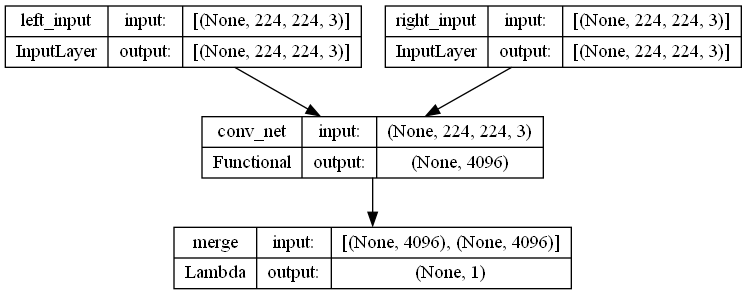

In [31]:
plot_model(model, show_shapes=True)
#model.summary()

In [ ]:
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
1/4 [======>.......................] - ETA: 4:01 - loss: 0.3210

### Performance metrics

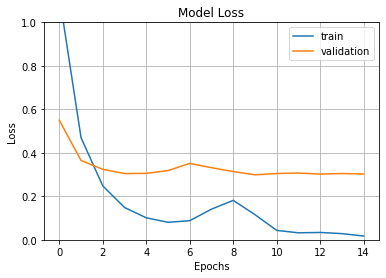

In [28]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0,ymax=1)
plt.grid()

plt.show()

### Predictions

In [29]:
test_ds_left = create_singular_dataset(X_test['left'])
test_ds_right = create_singular_dataset(X_test['right'])
test_labels = Y_test_label['label']

test_ds_full = create_dataset_no_labels(X_test)

In [30]:
left_image_feature_vectors = base_model.predict(test_ds_left)
right_image_feature_vectors = base_model.predict(test_ds_right)

4/4 [==============================] - 0s 19ms/step


In [31]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

### Positive distances

In [32]:
positive_distances = euclidean_distance((positive_left_image_feature_vectors, positive_right_image_feature_vectors)).numpy().flatten()
pd.Series(positive_distances).describe()

count    20.000000
mean      0.523917
std       0.562741
min       0.080270
25%       0.101518
50%       0.129585
75%       1.075535
max       1.959281
dtype: float64

### Negative distances

In [33]:
negative_distances = euclidean_distance((negative_left_image_feature_vectors, negative_right_image_feature_vectors)).numpy().flatten()
pd.Series(negative_distances).describe()

count    20.000000
mean      1.226193
std       0.529558
min       0.548611
25%       0.910652
50%       1.086052
75%       1.389910
max       2.397444
dtype: float64

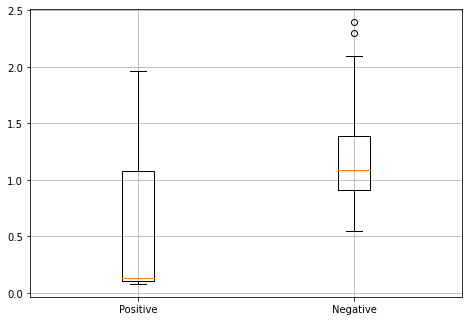

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [37]:
def compute_accuracy(y_true, y_pred):
    # 1 for the same - distance is smaller than 0.5, 0 for the different
    pred = y_pred.flatten() < 0.2
    return np.mean(pred == y_true)

In [38]:
y_pred_test = euclidean_distance((left_image_feature_vectors, right_image_feature_vectors)).numpy().flatten()
test_accuracy = compute_accuracy(test_labels, y_pred_test)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

Test accuracy: 80.00%
